In [128]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from datetime import datetime, timedelta

import seaborn as sns

from matplotlib import rcParams
from sklearn.linear_model import LinearRegression

from collections import Counter

LoadDatas
-----
- excel data structure
    - column.row
    - col.0 : B1
    - col.1 : B1_1_동
    - col.2 : B1_1_호수
    - col.3:end : timeslot

In [2]:
xlsx = pd.read_excel('datas.xlsx', 
                    header = None, 
                    skiprows = 2,
                    engine = 'openpyxl')

data_startcol = 7
ogDatasObj = {}
for col in xlsx:
    if col >= data_startcol: # startcol 7
        ogDatasObj[f'{xlsx[col][0]}-{xlsx[col][1]}-{xlsx[col][2]}'] = xlsx[col][3:]

ogDatas = pd.DataFrame(ogDatasObj)
ogDatas = ogDatas.fillna(0)
ogDatas = ogDatas.reset_index()
del ogDatas['index']

pd.set_option('display.max_row', 20)
pd.set_option('display.max_columns', 100)

ogDatas

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,아파트1-103-502,아파트1-103-1602,아파트1-103-301,아파트1-103-1502,아파트1-103-202,아파트1-102-903,아파트1-102-603,아파트1-102-203,아파트1-102-704,아파트1-102-703,아파트1-102-403,아파트1-102-303,아파트1-101-604,아파트1-101-1602,아파트1-101-1002,아파트1-101-1202,아파트1-101-1604,아파트1-101-402,아파트1-101-303,아파트1-101-502,아파트1-101-1403,아파트1-101-904,아파트1-101-1502,아파트1-101-1102,아파트1-101-901,아파트1-101-704,아파트1-101-504,아파트1-102-104,아파트1-102-301,아파트1-102-1501,아파트1-102-1602,아파트1-102-1002,아파트1-102-401,아파트1-102-802,아파트1-102-801,아파트1-103-505,아파트1-103-1805,아파트1-103-1306,아파트1-103-1806,아파트1-103-803,...,아파트4-103-609,아파트4-103-707,아파트4-103-101,아파트4-102-803,아파트4-101-1501,아파트4-103-404,아파트4-103-909,아파트4-101-1203,아파트4-103-806,아파트4-103-1410,아파트4-103-402,아파트4-103-703,아파트4-103-106,아파트4-103-910,아파트4-102-402,아파트4-103-907,아파트4-103-1406,아파트4-103-1006,아파트4-103-608,아파트4-103-403,아파트4-105-1102,아파트4-103-804,아파트4-103-103,아파트4-103-706,아파트4-104-1001,아파트4-105-103,아파트4-102-401,아파트4-103-1104,아파트4-103-906,아파트4-103-606,아파트4-103-1307,아파트4-103-410,아파트4-103-1309,아파트4-102-102,아파트4-103-508,아파트4-105-1104,아파트4-102-1402,아파트4-103-407,아파트4-103-1206,아파트4-103-108,아파트4-105-102,아파트4-103-1102,아파트4-105-601,아파트4-104-1501,아파트4-103-702,아파트4-102-104,아파트4-103-902,아파트4-101-602,아파트4-103-905,아파트4-101-104
0,0.085,0.016,0.052,0.003,0.032,0.074,0.053,0.096,0.105,0.042,0.149,0.039,0.054,0.132,0.091,0.169,0.051,0.118,0.060,0.047,0.047,0.053,0.046,0.104,0.079,0.092,0.043,0.069,0.139,0.026,0.146,0.092,0.025,0.127,0.045,0.042,0.113,0.207,0.030,0.171,0.045,0.064,0.045,0.277,0.186,0.142,0.132,0.034,0.088,0.041,...,0.041,0.137,0.114,0.046,0.098,0.058,0.068,0.040,0.063,0.048,0.168,0.053,0.099,0.075,0.080,0.158,0.024,0.153,0.056,0.037,0.091,0.069,0.128,0.092,0.072,0.069,0.034,0.166,0.086,0.113,0.184,0.175,0.096,0.054,0.080,0.084,0.119,0.088,0.117,0.161,0.182,0.044,0.051,0.057,0.126,0.094,0.065,0.116,0.093,0.147
1,0.086,0.049,0.053,0.002,0.022,0.014,0.048,0.090,0.108,0.022,0.119,0.023,0.075,0.142,0.063,0.183,0.045,0.164,0.065,0.066,0.043,0.056,0.045,0.130,0.081,0.102,0.042,0.083,0.176,0.046,0.113,0.088,0.026,0.116,0.066,0.050,0.139,0.188,0.031,0.165,0.032,0.068,0.052,0.244,0.209,0.205,0.161,0.039,0.094,0.036,...,0.036,0.083,0.124,0.055,0.115,0.068,0.072,0.032,0.085,0.111,0.173,0.050,0.103,0.068,0.076,0.360,0.031,0.132,0.038,0.037,0.097,0.075,0.123,0.072,0.053,0.059,0.023,0.135,0.143,0.112,0.101,0.163,0.154,0.078,0.036,0.076,0.092,0.042,0.121,0.179,0.117,0.060,0.036,0.055,0.116,0.089,0.083,0.113,0.105,0.130
2,0.085,0.013,0.073,0.002,0.016,0.051,0.029,0.033,0.097,0.046,0.116,0.018,0.071,0.096,0.159,0.122,0.043,0.141,0.097,0.064,0.055,0.054,0.051,0.119,0.109,0.097,0.056,0.086,0.126,0.036,0.113,0.079,0.027,0.170,0.072,0.044,0.163,0.201,0.053,0.163,0.041,0.071,0.046,0.256,0.173,0.199,0.122,0.028,0.084,0.026,...,0.045,0.081,0.115,0.063,0.070,0.053,0.078,0.036,0.083,0.111,0.084,0.053,0.084,0.071,0.087,0.471,0.024,0.079,0.047,0.036,0.078,0.059,0.137,0.084,0.083,0.056,0.036,0.106,0.160,0.108,0.184,0.162,0.124,0.135,0.053,0.073,0.108,0.056,0.100,0.224,0.147,0.053,0.075,0.032,0.131,0.055,0.084,0.153,0.119,0.104
3,0.085,0.043,0.067,0.002,0.015,0.015,0.031,0.092,0.048,0.067,0.102,0.031,0.128,0.082,0.104,0.141,0.031,0.103,0.075,0.082,0.046,0.016,0.046,0.078,0.070,0.073,0.051,0.085,0.098,0.048,0.145,0.078,0.021,0.142,0.062,0.034,0.149,0.194,0.038,0.065,0.043,0.070,0.043,0.274,0.047,0.108,0.162,0.034,0.069,0.038,...,0.039,0.086,0.068,0.035,0.064,0.061,0.065,0.022,0.066,0.087,0.080,0.047,0.079,0.066,0.029,0.187,0.030,0.059,0.055,0.035,0.080,0.074,0.090,0.066,0.071,0.062,0.034,0.114,0.121,0.108,0.051,0.170,0.068,0.072,0.074,0.078,0.101,0.080,0.084,0.178,0.152,0.047,0.064,0.022,0.104,0.057,0.087,0.149,0.102,0.093
4,0.084,0.033,0.051,0.003,0.022,0.052,0.052,0.030,0.041,0.045,0.102,0.032,0.122,0.069,0.089,0.103,0.011,0.094,0.084,0.053,0.047,0.022,0.048,0.040,0.077,0.089,0.041,0.092,0.062,0.045,0.109,0.109,0.033,0.084,0.069,0.035,0.225,0.199,0.078,

SetDatas
---
## 특정 가구를 날짜별로 나누는 작업
- timeslotDatas === tsDatas

In [231]:
startDate = datetime(2018,5,1)
endDate = datetime(2019,5,1)
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
dateIndexArr = [dt.strftime('%Y%m%d') for dt in
                   datetime_range(startDate, endDate, timedelta(days = 1))]

searchKeyword = '아파트1-104-1206'
tsDatasObj = {}
startIdx = 0;
endIdx = 96;
for date in dateIndexArr:
    tsDatasObj[date] = ogDatas[searchKeyword][startIdx:endIdx].values.tolist()
    startIdx = endIdx
    endIdx = endIdx + 96

tsDatas = pd.DataFrame(tsDatasObj)
tsDatas = tsDatas.T
tsDatas = tsDatas.reset_index()
tsDatas.rename(columns={'index':'date'}, inplace=True)
tsDatas['year'] = [dt[0:4] for dt in tsDatas['date']]
tsDatas['month'] = [dt[4:6] for dt in tsDatas['date']]
tsDatas['day'] = [dt[6:8] for dt in tsDatas['date']]
tsDatas['date'] = [datetime.strptime(dt, "%Y%m%d") for dt in tsDatas['date']]
tsDatas.reindex(columns=['date', 'year', 'month', 'day'])

,date,year,month,day
0,2018-05-01,2018,05,01
1,2018-05-02,2018,05,02
2,2018-05-03,2018,05,03
3,2018-05-04,2018,05,04
4,2018-05-05,2018,05,05
...,...,...,...,...
360,2019-04-26,2019,04,26
361,2019-04-27,2019,04,27
362,2019-04-28,2019,04,28
363,2019-04-29,2019,04,29


Select Season, Day
---
## 해당 가구의 데이터 중에서 계절, 날짜에 맞게 변환

In [280]:
DAYS = {
    "월" : 0,
    "화" : 1,
    "수" : 2,
    "목" : 3,
    "금" : 4,
    "토" : 5,
    "일" : 6
}

SEASONS = {
    "봄" : ["03", "04", "05"],
    "여름" : ["06", "07", "08"],
    "가을" : ["09", "10", "11"],
    "겨울" : ["12", "01", "02"]
}

ALLDATAS = False
DAY = "월"
SEASON = "여름"
# ALLDATAS is tsDatas
if ALLDATAS:
    datas = tsDatas
else :    
    datas = tsDatas[(tsDatas['month'].isin(SEASONS[SEASON]))
            & (tsDatas['date'].dt.weekday == DAYS[DAY]) ]
datas

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,year,month,day
34,2018-06-04,0.064,0.057,0.058,0.056,0.052,0.051,0.051,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.050,0.050,0.050,0.050,0.050,0.051,0.050,0.054,0.056,0.055,0.040,0.055,0.057,0.103,0.056,0.053,0.052,0.052,0.052,0.051,0.052,0.051,0.051,0.050,0.051,0.051,0.051,0.051,0.051,0.051,0.052,0.051,0.052,0.051,0.051,0.051,0.050,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.050,0.051,0.051,0.051,0.050,0.052,0.050,0.051,0.050,0.051,0.050,0.051,0.054,0.057,0.056,0.073,0.097,0.085,0.083,0.083,0.082,0.102,0.105,0.102,0.105,0.105,0.108,0.109,0.108,0.108,0.083,0.078,0.077,0.059,2018,06,04
41,2018-06-11,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.097,0.100,0.098,0.062,0.061,0.061,0.060,0.061,0.060,0.060,0.059,0.064,0.066,0.065,0.048,0.064,0.062,0.062,0.060,0.062,0.061,0.061,0.065,0.079,0.050,0.051,0.051,0.050,0.051,0.051,0.051,0.052,0.050,0.051,0.050,0.050,0.050,0.051,0.051,0.051,0.050,0.049,0.050,0.050,0.050,0.051,0.050,0.050,0.051,0.050,0.051,0.051,0.050,0.051,0.051,0.045,0.031,0.051,0.051,0.051,0.051,0.030,0.047,0.051,0.054,0.056,0.057,0.043,0.053,0.054,0.053,0.053,0.052,0.052,0.052,0.052,0.069,0.090,0.086,0.081,0.081,0.082,0.085,0.086,0.079,0.058,0.060,0.059,2018,06,11
48,2018-06-18,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.060,0.055,0.054,0.055,0.054,0.054,0.054,0.054,0.054,0.054,0.053,0.054,0.054,0.053,0.054,0.054,0.053,0.053,0.054,0.053,0.053,0.053,0.054,0.053,0.054,0.053,0.054,0.053,0.053,0.054,0.053,0.053,0.054,0.054,0.053,0.053,0.054,0.053,0.054,0.053,0.053,0.054,0.052,0.055,0.058,0.082,0.087,0.091,0.095,0.102,0.095,0.094,0.093,0.090,0.089,0.090,0.089,0.072,0.059,0.058,0.059,2018,06,18
55,2018-06-25,0.068,0.059,0.058,0.059,0.058,0.058,0.059,0.058,0.058,0.057,0.056,0.057,0.056,0.057,0.057,0.056,0.057,0.060,0.062,0.062,0.046,0.061,0.059,0.059,0.058,0.057,0.058,0.057,0.057,0.057,0.058,0.090,0.052,0.050,0.051,0.050,0.050,0.051,0.051,0.050,0.051,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.049,0.050,0.050,0.050,0.050,0.050,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.050,0.051,0.051,0.054,0.057,0.057,0.041,0.055,0.053,0.051,0.052,0.052,0.051,0.052,0.051,0.050,0.050,0.051,0.050,0.051,0.054,0.229,0.359,0.369,0.300,0.139,0.089,0.087,0.080,0.317,0.321,2018,06,25
62,2018-07-02,0.050,0.050,0.048,0.030,0.049,0.050,0.051,0.050,0.050,0.050,0.053,0.056,0.127,0.300,0.189,0.181,0.160,0.128,0.059,0.059,0.057,0.058,0.057,0.056,0.057,0.056,0.056,0.056,0.057,0.057,0.057,0.067,0.105,0.052,0.053,0.053,0.053,0.053,0.053,0.054,0.053,0.053,0.053,0.053,0.053,0.036,0.047,0.054,0.054,0.054,0.055,0.054,0.053,0.054,0.053,0.053,0.053,0.053,0.053,0.047,0.032,0.054,0.053,0.053,0.059,0.058,0.059,0.043,0.058,0.056,0.055,0.055,0.055,0.055,0.054,0.054,0.054,0.054,0.053,0.054,0.089,0.343,0.361,0.127,0.094,0.096,0.078,0.061,0.062,0.061,0.061,0.061,0.061,0.060,0.060,0.060,2018,07,02
69,2018-07-09,0.216,0.192,0.181,0.164,0.181,0.183,0.162,0.174,0.183,0.156,0.057,0.058,0.057,0.056,0.056,0.057,0.056,0.056,0.056,0.056,0.056,0.056,0.057,0.055,0.056,0.055,0.056,0.057,0.057,0.056,0.057,0.059,0.086,0.050,0.049,0.050,0.050,0.049,0.051,0.049,0.050,0.050,0.049,0.050,0.050,0.050,0.050,0.050,0.051,0.050,0.050,0.050,0.050,0.050,0.053,0.057,0.057,0.040,0.055,0.053,0.052,0.051,0.052,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.050,0.051,0.050,0.051,0.050,0.050,0.070,0.114,0.080,0.080,0.080,0.080,0.081,0.082,0.081,0.081,0.082,0.081,0.081,0.082,0.082,0.081,0.081,0.081,0.081,0.080,2018,07,09
76,2018-07-16,0.055,0.055,0.055,0.055,0.054,0.055,0.055,0.054,0.054,0.054,0.055,0.054,0.054,0.0

In [279]:
remove_outlier = datas[datas.columns.difference(['date', 'year', 'month', 'day'])].copy()
remove_outlier

outlier_indices = []
for col in remove_outlier:
    Q1 = np.percentile(remove_outlier[col], 25)
    print(Q1)
    Q3 = np.percentile(remove_outlier[col], 75)
    print(Q3)
    IQR = Q3 - Q1
    
    outlier_step = 1.5 * IQR
    
    outlier_list_col = remove_outlier[(remove_outlier[col] < Q1 - outlier_step) | 
                          (remove_outlier[col] > Q3 + outlier_step)].index
    outlier_indices.extend(outlier_list_col)
outlier_indices = Counter(outlier_indices)
multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)

multiple_outliers

0.06
0.145
0.059
0.097
0.058
0.181
0.058
0.164
0.058
0.197
0.058
0.177
0.059
0.162
0.058
0.165
0.057
0.183
0.054
0.156
0.055
0.098
0.056
0.06
0.056
0.061
0.056
0.061
0.057
0.106
0.057
0.061
0.056
0.06
0.057
0.06
0.056
0.06
0.056
0.062
0.055
0.06
0.056
0.061
0.057
0.059
0.055
0.06
0.057
0.06
0.055
0.06
0.056
0.06
0.057
0.166
0.057
0.172
0.057
0.157
0.057
0.27
0.067
0.209
0.052
0.13
0.051
0.06
0.05
0.056
0.05
0.058
0.051
0.055
0.05
0.053
0.051
0.055
0.05
0.054
0.051
0.054
0.05
0.054
0.05
0.054
0.05
0.054
0.051
0.054
0.051
0.053
0.05
0.054
0.051
0.054
0.051
0.054
0.05
0.054
0.051
0.054
0.05
0.053
0.05
0.053
0.051
0.053
0.051
0.053
0.051
0.053
0.051
0.053
0.05
0.053
0.051
0.053
0.05
0.052
0.05
0.052
0.051
0.054
0.051
0.053
0.05
0.053
0.05
0.052
0.05
0.053
0.05
0.053
0.051
0.053
0.05
0.054
0.051
0.054
0.05
0.053
0.051
0.053
0.051
0.054
0.051
0.054
0.051
0.054
0.052
0.053
0.052
0.054
0.051
0.054
0.052
0.08
0.052
0.085
0.052
0.082
0.052
0.081
0.052
0.082
0.052
0.082
0.053
0.081
0.054
0.095
0.

[97, 111, 69, 104, 83, 62, 118, 76, 34, 90, 55, 41]

In [275]:
datas = datas.drop(multiple_outliers)
datas

KeyError: '[ 97 111  69 104  83  62 118  76  34  90  55  41] not found in axis'

In [244]:
'''
dr.reset_index(inplace=True)
dr = dr[dr.columns.difference(['date'])]

q1 = np.percentile(dr, 25)
q3 = np.percentile(dr, 75)

IQR = q3 - q1
IQR_weight = IQR * 1.5
lowest = q1 - IQR_weight
highest = q3 + IQR_weight

condition = (dr < lowest) | (dr > highest)
condition = condition.any(axis = 1)
condition

search = dr[condition]
search

dr = dr.drop(search.index, axis=0)
'''

"\ndr.reset_index(inplace=True)\ndr = dr[dr.columns.difference(['date'])]\n\nq1 = np.percentile(dr, 25)\nq3 = np.percentile(dr, 75)\n\nIQR = q3 - q1\nIQR_weight = IQR * 1.5\nlowest = q1 - IQR_weight\nhighest = q3 + IQR_weight\n\ncondition = (dr < lowest) | (dr > highest)\ncondition = condition.any(axis = 1)\ncondition\n\nsearch = dr[condition]\nsearch\n\ndr = dr.drop(search.index, axis=0)\n"

DataPreprocessing
---
- 데이터 전처리
    - StandardScaler : 각 특성의 평균을 0, 분산을 1로 변경하여 특성의
        스케일을 맞춘다.

In [281]:
dpp = datas[datas.columns.difference(['date', 'year', 'month', 'day'])].copy()
dpp = dpp

# Scaler 선택
# STD, MIN, MAX, ROBUST
selScaler = "ROBUST"

scaler = StandardScaler()
if selScaler == "STD":
    scaler = StandardScaler()
elif selScaler == "MIN":
    scaler = MinMaxScaler()
elif selScaler == "MAX":
    scaler = MaxAbsScaler()
elif selScaler == "ROBUST":
    scaler = RobustScaler()

dpp = pd.DataFrame(scaler.fit_transform(dpp))

dpp.index = datas['date']
dpp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-04,-0.200000,-0.631579,-0.178862,-0.245283,-0.201439,-0.252101,-0.281553,-0.271028,-0.079365,-0.058824,-0.162791,-1.75,-1.6,-1.2,-0.163265,-1.75,-2.00,-2.666667,-2.25,-1.166667,-1.4,-1.4,-3.5,-0.8,-0.333333,-0.4,-4.50,-0.027523,-0.008696,0.43,-0.014085,-0.260563,-0.102564,-0.222222,0.000000,-0.250,0.00,0.000000,-0.50,-0.50,-0.666667,0.00,-0.25,-0.50,-0.666667,-0.5,0.00,-0.666667,-0.333333,-0.50,-0.333333,-0.333333,-0.666667,-0.5,-0.5,-0.5,-0.5,0.000000,-0.5,0.0,0.0,-0.333333,-0.5,0.000000,0.0,0.000000,-0.333333,0.5,-0.25,-0.333333,-0.666667,0.0,-1.000000,-0.333333,0.666667,4.0,1.0,6.666667,1.571429,0.939394,0.233333,0.206897,0.233333,0.833333,1.178571,0.512195,1.277778,1.20,1.35,1.217391,1.125000,1.20,0.272727,0.000000,0.000000,-0.782609
2018-06-11,0.188235,0.421053,0.138211,0.141509,0.122302,0.134454,0.165049,0.158879,0.293651,0.421569,0.953488,1.00,0.6,0.8,0.040816,0.75,0.50,0.666667,0.00,1.166667,1.8,1.4,-4.5,1.2,1.666667,1.0,0.50,0.036697,0.026087,0.01,0.028169,-0.077465,-0.128205,-0.333333,-0.166667,-0.375,-0.25,0.000000,-0.50,0.00,-1.000000,0.00,-0.50,-0.75,-1.000000,-0.5,-0.25,-0.666667,-1.000000,-1.00,-0.666667,-0.666667,-0.666667,-0.5,-1.0,-1.0,-0.5,-0.333333,-0.5,0.0,-0.5,-0.333333,0.0,-2.000000,-10.0,0.000000,0.000000,0.0,0.00,-7.333333,-1.666667,0.0,0.333333,1.333333,1.666667,-10.0,-0.5,0.333333,0.000000,-0.030303,-0.800000,-0.862069,-0.766667,-0.833333,-0.107143,0.219512,0.222222,0.00,0.00,0.043478,0.166667,0.32,-0.090909,-0.909091,-0.809524,-0.782609
2018-06-18,-0.247059,-0.552632,-0.162602,-0.207547,-0.143885,-0.176471,-0.194175,-0.186916,0.000000,0.029412,0.069767,0.50,0.4,0.6,0.040816,0.50,0.50,0.666667,0.25,0.500000,0.6,0.4,1.5,0.4,1.000000,0.6,0.50,0.018349,0.017391,0.00,0.004695,-0.211268,0.000000,0.666667,1.333333,0.875,0.75,1.000000,0.50,0.50,0.333333,0.75,0.50,0.25,0.333333,0.5,0.50,0.333333,0.000000,0.25,0.666667,0.333333,0.333333,1.0,0.5,0.5,0.5,1.000000,0.5,1.5,1.0,0.666667,1.0,0.666667,1.5,0.666667,0.666667,1.5,0.75,0.333333,0.333333,1.5,0.000000,0.666667,0.333333,0.0,0.0,-0.333333,0.071429,0.121212,0.200000,0.344828,0.533333,0.600000,1.071429,0.341463,0.666667,0.60,0.45,0.347826,0.375000,0.44,-0.727273,-0.863636,-0.904762,-0.782609
2018-06-25,-0.152941,-0.578947,-0.178862,-0.216981,-0.158273,-0.193277,-0.203883,-0.205607,-0.015873,0.000000,-0.023256,-0.25,-0.4,0.0,-0.020408,-0.50,-0.25,0.666667,0.75,0.833333,-2.2,0.6,1.0,0.2,0.333333,0.0,0.00,-0.009174,-0.008696,-0.03,-0.004695,0.000000,-0.102564,-0.444444,-0.166667,-0.375,-0.50,0.000000,-0.50,-0.50,-0.666667,-0.25,-0.50,-0.75,-1.000000,-1.0,-0.50,-1.000000,-1.000000,-0.75,-1.000000,-0.666667,-0.666667,-1.0,-1.0,-1.0,-0.5,-0.333333,-0.5,-0.5,0.0,-0.666667,0.0,-0.333333,0.0,-0.333333,0.000000,0.0,0.75,1.666667,1.666667,-5.0,0.666667,0.333333,-0.333333,-1.0,-1.0,-0.666667,-0.035714,-0.090909,-0.866667,-0.931034,-0.800000,-0.900000,-0.750000,-0.658537,8.166667,13.90,14.40,9.521739,2.416667,0.44,0.636364,0.090909,11.428571,10.608696
2018-07-02,-0.364706,-0.815789,-0.260163,-0.490566,-0.223022,-0.260504,-0.281553,-0.280374,-0.079365,-0.068627,-0.093023,-0.50,13.8,48.6,2.673469,30.75,25.50,23.333333,0.00,0.333333,0.0,0.0,0.0,-0.4,0.000000,-0.2,-0.50,-0.018349,-0.008696,-0.03,-0.009390,-0.161972,0.576923,-0.222222,0.166667,0.000,0.25,0.666667,0.00,0.50,0.000000,0.50,0.25,0.00,0.000000,-8.0,-1.25,0.333333,0.333333,0.25,1.000000,0.666667,0.333333,1.0,0.5,0.5,0.5,0.666667,0.5,-2.0,-9.5,0.666667,1.0,0.666667,4.0,2.333333,2.666667,-4.0,1.75,1.333333,1.000000,2.0,0.666667,1.000000,0.666667,1.0,0.0,0.333333,0.000000,0.000000,0.433333,9.172414,9.533333,1.666667,0.785714,0.365854,-0.2

Dimensionality Reduction
---
- 차원축소
    - PCA : Principal component analysis, 주성분 분석

In [282]:
pca = PCA(n_components=2)

pca.fit(dpp)
dr = pd.DataFrame(pca.transform(dpp), columns = ['x','y'])

dr.index = datas['date']
dr

,x,y
date,,
2018-06-04,-17.205005,-39.481559
2018-06-11,-13.973749,-32.917233
2018-06-18,-12.031088,-30.238112
2018-06-25,-12.117043,-35.429985
2018-07-02,-27.754690,-5.542892
2018-07-09,-14.499772,-39.202300
2018-07-16,-3.907852,2.717680
2018-07-23,-75.627042,97.895851
2018-07-30,196.289372,53.084507


In [283]:
'''
dr.reset_index(inplace=True)
dr = dr[dr.columns.difference(['date'])]

q1 = np.percentile(dr, 25)
q3 = np.percentile(dr, 75)

IQR = q3 - q1
IQR_weight = IQR * 1.5
lowest = q1 - IQR_weight
highest = q3 + IQR_weight

condition = (dr < lowest) | (dr > highest)
condition = condition.any(axis = 1)
condition

search = dr[condition]
search

dr = dr.drop(search.index, axis=0)
'''

"\ndr.reset_index(inplace=True)\ndr = dr[dr.columns.difference(['date'])]\n\nq1 = np.percentile(dr, 25)\nq3 = np.percentile(dr, 75)\n\nIQR = q3 - q1\nIQR_weight = IQR * 1.5\nlowest = q1 - IQR_weight\nhighest = q3 + IQR_weight\n\ncondition = (dr < lowest) | (dr > highest)\ncondition = condition.any(axis = 1)\ncondition\n\nsearch = dr[condition]\nsearch\n\ndr = dr.drop(search.index, axis=0)\n"

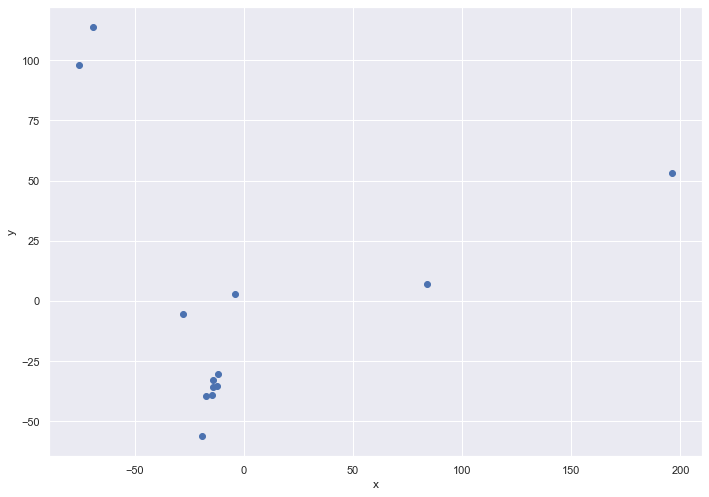

In [284]:
plt.scatter(dr['x'], dr['y'], marker = 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

KMeans Clustering
---

In [285]:
K = 4

points = dr.values
kmeans = KMeans(n_clusters=K).fit(points)
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['x', 'y'])

clusterNum = [i for i in range(K)]
centers['cluster'] = [i for i in range(len(centers))]
centers['type'] = [f'cluster' for dt in clusterNum]
centers

,x,y,cluster,type
0,-15.029914,-30.200652,0,cluster
1,196.289372,53.084507,1,cluster
2,-72.336298,105.817664,2,cluster
3,83.652447,7.086031,3,cluster


In [286]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 3, 0], dtype=int32)

In [287]:
clustering = dr
clustering['cluster'] = kmeans.labels_
clustering['type'] = ['data' for i in range(len(clustering['x']))]

result = pd.concat([clustering, centers], axis = 0)

result

,x,y,cluster,type
2018-06-04 00:00:00,-17.205005,-39.481559,0,data
2018-06-11 00:00:00,-13.973749,-32.917233,0,data
2018-06-18 00:00:00,-12.031088,-30.238112,0,data
2018-06-25 00:00:00,-12.117043,-35.429985,0,data
2018-07-02 00:00:00,-27.754690,-5.542892,0,data
2018-07-09 00:00:00,-14.499772,-39.202300,0,data
2018-07-16 00:00:00,-3.907852,2.717680,0,data
2018-07-23 00:00:00,-75.627042,97.895851,2,data
2018-07-30 00:00:00,196.289372,53.084507,1,data
2018-08-06 00:00:00,-14.392707,-35.629537,0,data


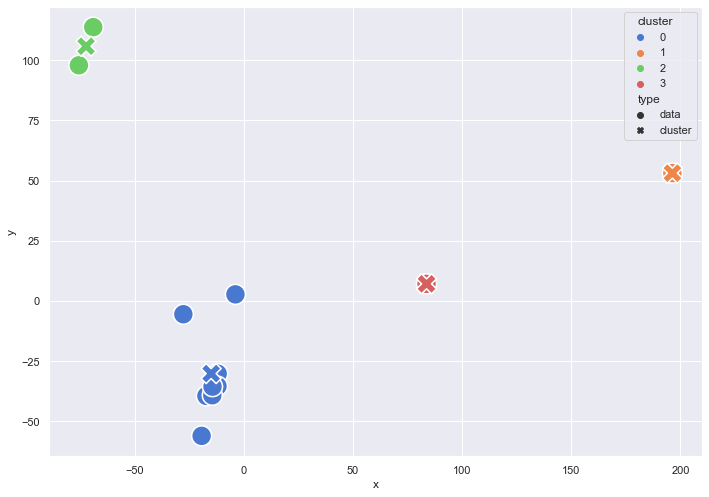

In [288]:
sns.scatterplot(x='x', y="y", 
                hue="cluster", 
                style="type",
                palette="muted",
                s=400,
                data=result)
sns.set(rc={'figure.figsize': (11.7, 8.27)})
rcParams['figure.figsize'] = 11.7,8.27
plt.title = "클러스터링 결과물"
plt.show()

1안 : 일반 적인 그룹핑 데이터
---

<AxesSubplot:>

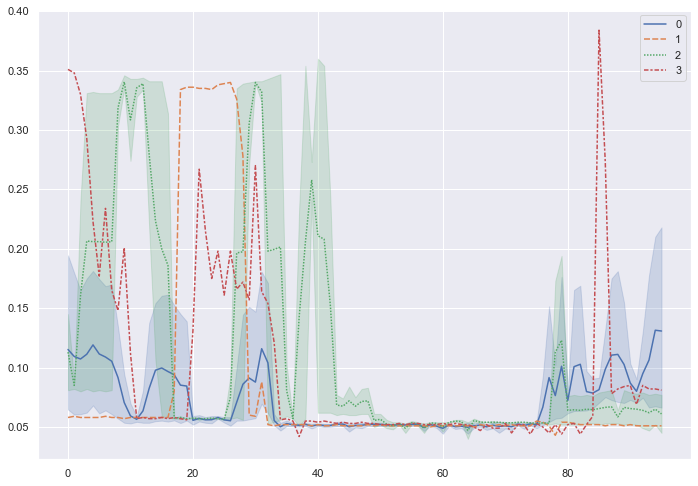

In [289]:
tsCheck = datas[datas.columns.difference(['year', 'month', 'day'])]
tsCheck.reset_index(inplace=True)
del tsCheck['index']
tsCheck = tsCheck.set_index('date')
tsCheck['cluster'] = clustering['cluster']
tsCheck.reset_index(inplace=True)
tsCheck.set_index(['cluster', 'date'], inplace=True)
tsCheck = tsCheck.T
tsCheck
sns.lineplot(data=tsCheck)

2안 : 데이터 전처리 데이터
---

<AxesSubplot:>

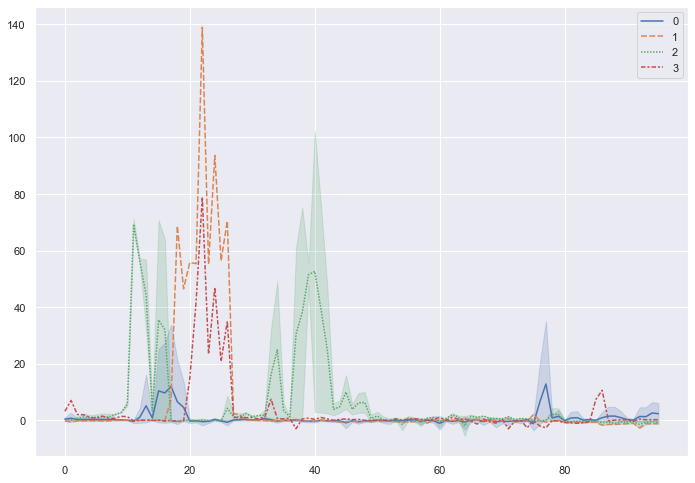

In [290]:
dppCheck = dpp.copy()
dppCheck['cluster'] = clustering['cluster']
dppCheck.reset_index(inplace=True)
dppCheck.set_index(['cluster', 'date'], inplace=True)
dppCheck = dppCheck.T
dppCheck
sns.lineplot(data=dppCheck)

3안 : 데이터 군집이 잘 이루어졌는지 확인하기
---

In [291]:
'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
processingData = [];
for d in tsCheck:
    for idx,t in enumerate(tsCheck[d]):
        processingData.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t
        })
processingData = pd.DataFrame(processingData)
processingData

,date,timeslot,cluster,data
0,2018-06-04,0,cluster-0,0.064
1,2018-06-04,1,cluster-0,0.057
2,2018-06-04,2,cluster-0,0.058
3,2018-06-04,3,cluster-0,0.056
4,2018-06-04,4,cluster-0,0.052
...,...,...,...,...
1243,2018-08-27,91,cluster-0,0.071
1244,2018-08-27,92,cluster-0,0.081
1245,2018-08-27,93,cluster-0,0.079
1246,2018-08-27,94,cluster-0,0.073


<AxesSubplot:xlabel='timeslot', ylabel='data'>

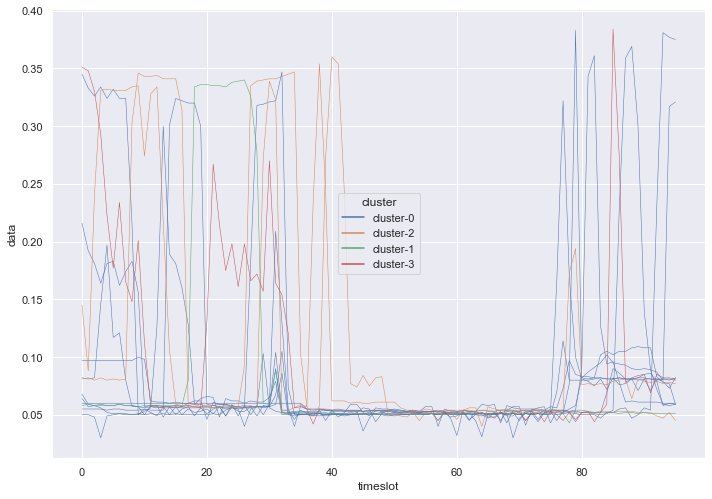

In [292]:
sns.lineplot(data=processingData,
            x="timeslot",
            y="data",
            units="date",
            hue="cluster",
            estimator=None,
            lw=0.5)

<AxesSubplot:xlabel='timeslot', ylabel='data'>

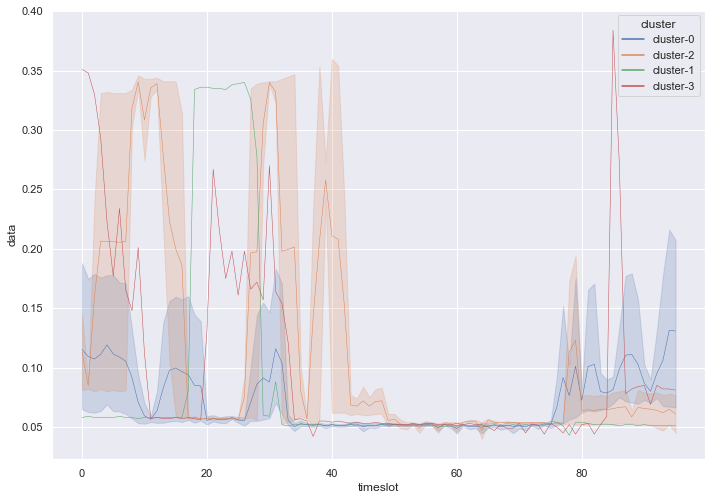

In [293]:
sns.lineplot(data=processingData,
            x="timeslot",
            y="data",
            hue="cluster",
            lw=0.5,
            err_style="band") # bars

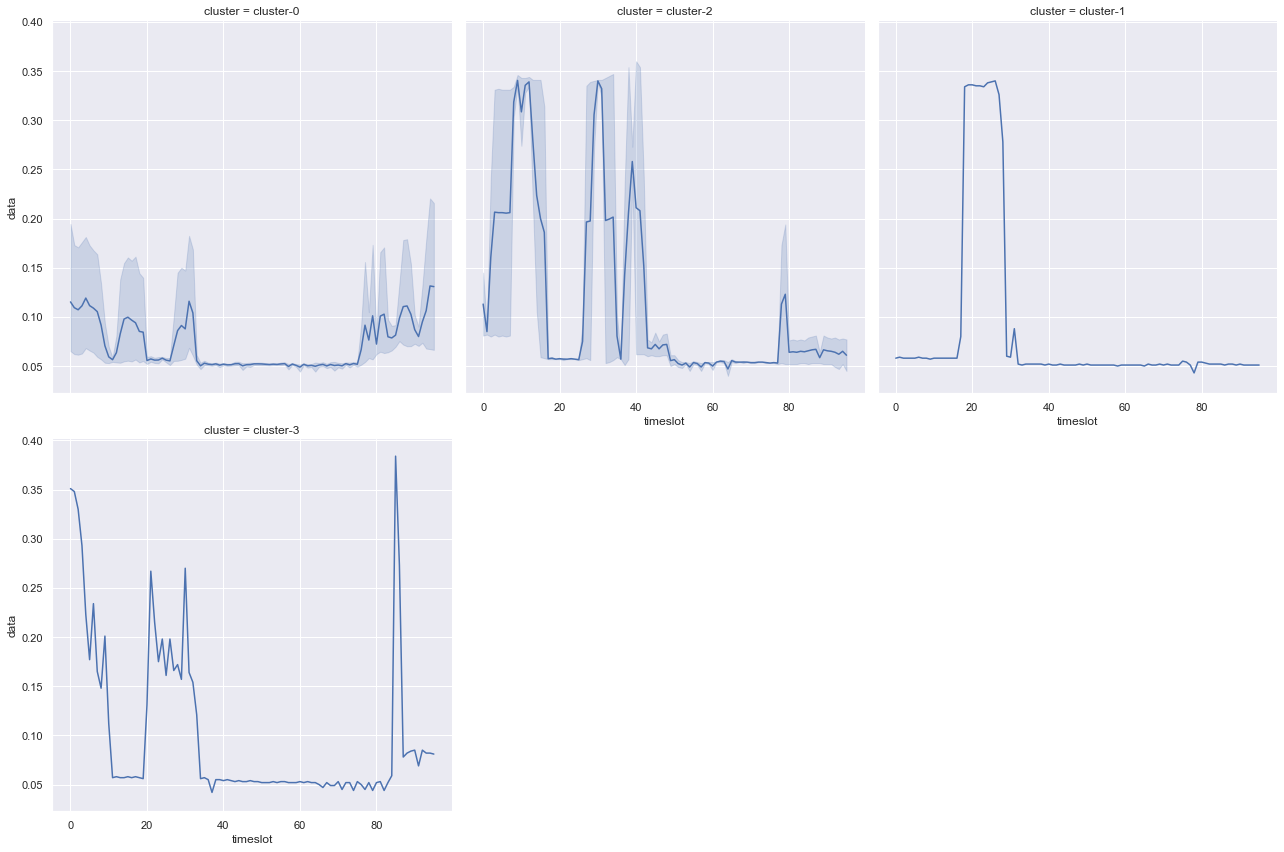

In [294]:
clusterMap = sns.FacetGrid(processingData, col = 'cluster', col_wrap=3, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data")

4안 : Moving Average 가 잘 조화되는지 확인
---

In [295]:
maTest = tsCheck.copy()
maTest

timeslot_3H = maTest.rolling(12).mean()
# timeslot_3H.fillna(0, inplace=True)
timeslot_3H

# sns.lineplot(data=timeslot_3H)

cluster          0                                                         \
date    2018-06-04 2018-06-11 2018-06-18 2018-06-25 2018-07-02 2018-07-09   
0              NaN        NaN        NaN        NaN        NaN        NaN   
1              NaN        NaN        NaN        NaN        NaN        NaN   
2              NaN        NaN        NaN        NaN        NaN        NaN   
3              NaN        NaN        NaN        NaN        NaN        NaN   
4              NaN        NaN        NaN        NaN        NaN        NaN   
..             ...        ...        ...        ...        ...        ...   
91        0.100000   0.072333   0.091417   0.149250   0.124500   0.081167   
92        0.100000   0.074583   0.090583   0.152333   0.122167   0.081250   
93        0.099583   0.075083   0.088250   0.154833   0.098583   0.081333   
94        0.099167   0.075750   0.085500   0.177000   0.073500   0.081333   
95        0.095583   0.076333   0.082500   0.199583   0.067917   0.081167   

cluster                     2          1          0          2          3  \
date    2018-07-16 2018-07-23 2018-07-30 2018-08-06 2018-08-13 2018-08-20   
0              NaN        NaN        NaN        NaN        NaN        NaN   
1              NaN        NaN        NaN        NaN        NaN        NaN   
2              NaN        NaN        NaN        NaN        NaN        NaN   
3              NaN        NaN        NaN        NaN        NaN        NaN   
4              NaN        NaN        NaN        NaN        NaN        NaN   
..             ...        ...        ...        ...        ...        ...   
91        0.081250   0.077000   0.052000   0.051917   0.052417   0.109583   
92        0.081083   0.077250   0.051750   0.066750   0.052167   0.112333   
93        0.081083   0.077250   0.051583   0.094167   0.051750   0.114750   
94        0.080917   0.077417   0.051500   0.121417   0.051750   0.117917   
95        0.080917   0.077417   0.051417   0.148750   0.051083   0.120333   

cluster          0  
date    2018-08-27  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
..             ...  
91        0.077250  
92        0.077250  
93        0.077250  
94        0.077083  
95        0.077167  

[96 rows x 13 columns]

In [296]:
'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
ma = [];
for d in timeslot_3H:
    for idx,t in enumerate(timeslot_3H[d]):
        ma.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t
        })
ma = pd.DataFrame(ma)
ma

,date,timeslot,cluster,data
0,2018-06-04,0,cluster-0,NaN
1,2018-06-04,1,cluster-0,NaN
2,2018-06-04,2,cluster-0,NaN
3,2018-06-04,3,cluster-0,NaN
4,2018-06-04,4,cluster-0,NaN
...,...,...,...,...
1243,2018-08-27,91,cluster-0,0.077250
1244,2018-08-27,92,cluster-0,0.077250
1245,2018-08-27,93,cluster-0,0.077250
1246,2018-08-27,94,cluster-0,0.077083


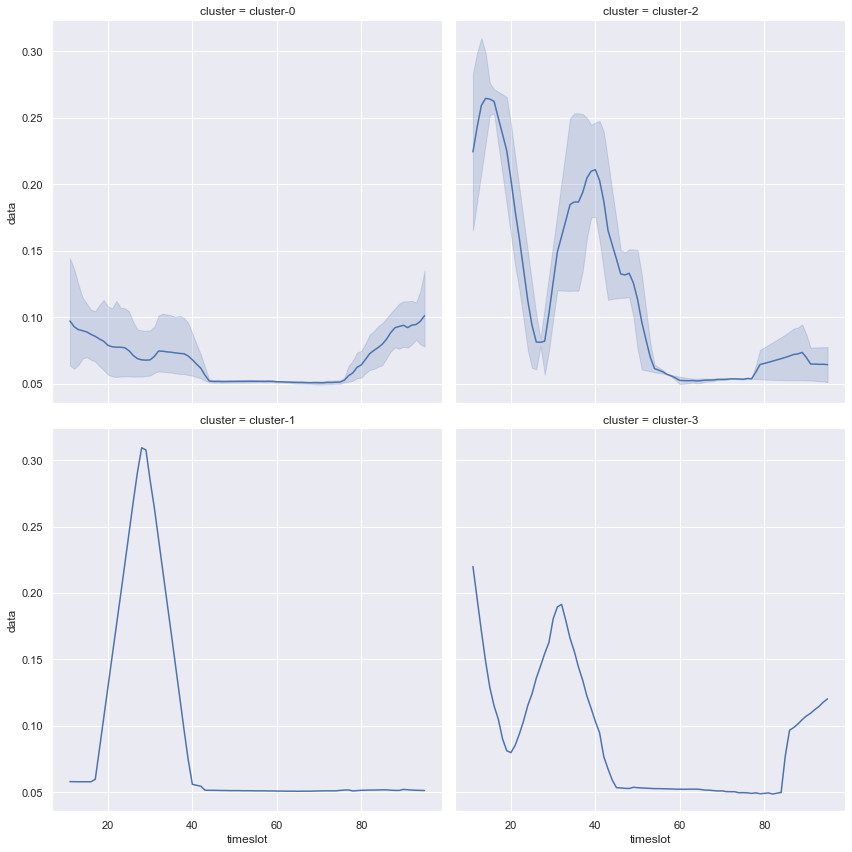

In [297]:
clusterMap = sns.FacetGrid(ma, col = 'cluster', col_wrap=2, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data")

In [298]:
processingData['type'] = 'processingData'
processingData

,date,timeslot,cluster,data,type
0,2018-06-04,0,cluster-0,0.064,processingData
1,2018-06-04,1,cluster-0,0.057,processingData
2,2018-06-04,2,cluster-0,0.058,processingData
3,2018-06-04,3,cluster-0,0.056,processingData
4,2018-06-04,4,cluster-0,0.052,processingData
...,...,...,...,...,...
1243,2018-08-27,91,cluster-0,0.071,processingData
1244,2018-08-27,92,cluster-0,0.081,processingData
1245,2018-08-27,93,cluster-0,0.079,processingData
1246,2018-08-27,94,cluster-0,0.073,processingData


In [299]:
ma['type'] = 'movingaverage'
ma

,date,timeslot,cluster,data,type
0,2018-06-04,0,cluster-0,NaN,movingaverage
1,2018-06-04,1,cluster-0,NaN,movingaverage
2,2018-06-04,2,cluster-0,NaN,movingaverage
3,2018-06-04,3,cluster-0,NaN,movingaverage
4,2018-06-04,4,cluster-0,NaN,movingaverage
...,...,...,...,...,...
1243,2018-08-27,91,cluster-0,0.077250,movingaverage
1244,2018-08-27,92,cluster-0,0.077250,movingaverage
1245,2018-08-27,93,cluster-0,0.077250,movingaverage
1246,2018-08-27,94,cluster-0,0.077083,movingaverage


In [300]:
pdma = pd.concat([processingData, ma], ignore_index=True)
pdma

,date,timeslot,cluster,data,type
0,2018-06-04,0,cluster-0,0.064000,processingData
1,2018-06-04,1,cluster-0,0.057000,processingData
2,2018-06-04,2,cluster-0,0.058000,processingData
3,2018-06-04,3,cluster-0,0.056000,processingData
4,2018-06-04,4,cluster-0,0.052000,processingData
...,...,...,...,...,...
2491,2018-08-27,91,cluster-0,0.077250,movingaverage
2492,2018-08-27,92,cluster-0,0.077250,movingaverage
2493,2018-08-27,93,cluster-0,0.077250,movingaverage
2494,2018-08-27,94,cluster-0,0.077083,movingaverage


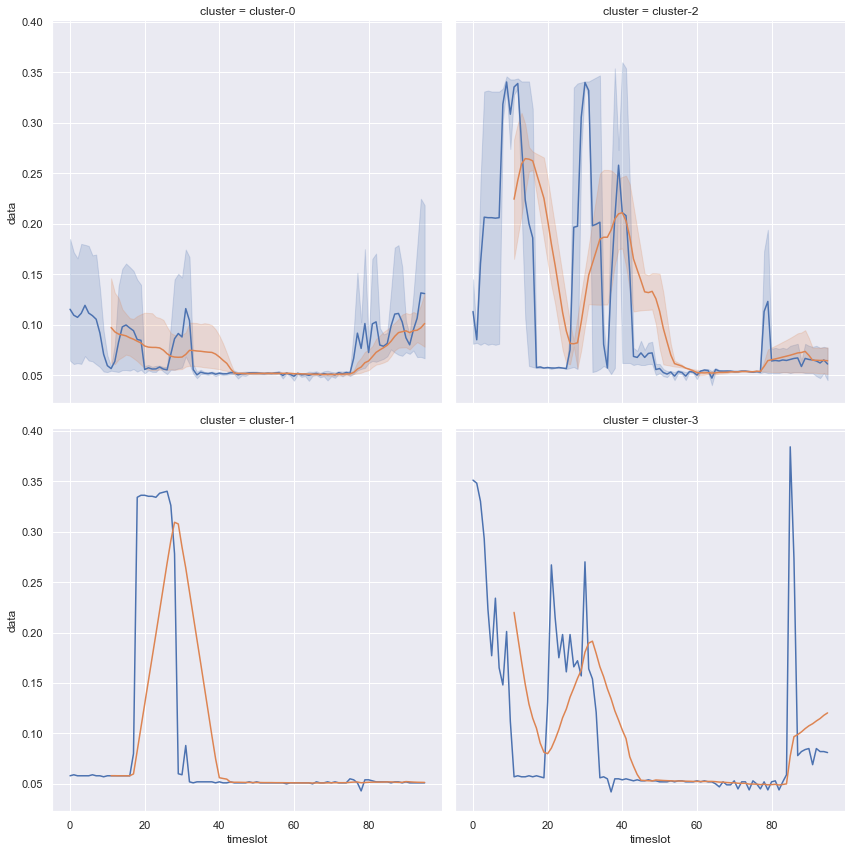

In [301]:
clusterMap = sns.FacetGrid(pdma, col = 'cluster', col_wrap=2, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data", "type")

EMA(Exponential MA)
---

In [302]:
emaTest = tsCheck.copy()
emaTest

timeslot_3H = emaTest.ewm(span=12).mean()
timeslot_3H

'''
Data Structure
{
    date: datetime,
    timeslot: integer,
    cluster: string,
    data: float
}
'''
ema = [];
for d in timeslot_3H:
    for idx,t in enumerate(timeslot_3H[d]):
        ema.append({
            "date": d[1],
            "timeslot": idx,
            "cluster": f"cluster-{d[0]}",
            "data": t,
            "type": "exponential moving average"
        })
ema = pd.DataFrame(ema)
ema

,date,timeslot,cluster,data,type
0,2018-06-04,0,cluster-0,0.064000,exponential moving average
1,2018-06-04,1,cluster-0,0.060208,exponential moving average
2,2018-06-04,2,cluster-0,0.059346,exponential moving average
3,2018-06-04,3,cluster-0,0.058290,exponential moving average
4,2018-06-04,4,cluster-0,0.056581,exponential moving average
...,...,...,...,...,...
1243,2018-08-27,91,cluster-0,0.081515,exponential moving average
1244,2018-08-27,92,cluster-0,0.081436,exponential moving average
1245,2018-08-27,93,cluster-0,0.081061,exponential moving average
1246,2018-08-27,94,cluster-0,0.079821,exponential moving average


In [303]:
pdma = pd.concat([pdma, ema])
pdma

,date,timeslot,cluster,data,type
0,2018-06-04,0,cluster-0,0.064000,processingData
1,2018-06-04,1,cluster-0,0.057000,processingData
2,2018-06-04,2,cluster-0,0.058000,processingData
3,2018-06-04,3,cluster-0,0.056000,processingData
4,2018-06-04,4,cluster-0,0.052000,processingData
...,...,...,...,...,...
1243,2018-08-27,91,cluster-0,0.081515,exponential moving average
1244,2018-08-27,92,cluster-0,0.081436,exponential moving average
1245,2018-08-27,93,cluster-0,0.081061,exponential moving average
1246,2018-08-27,94,cluster-0,0.079821,exponential moving average


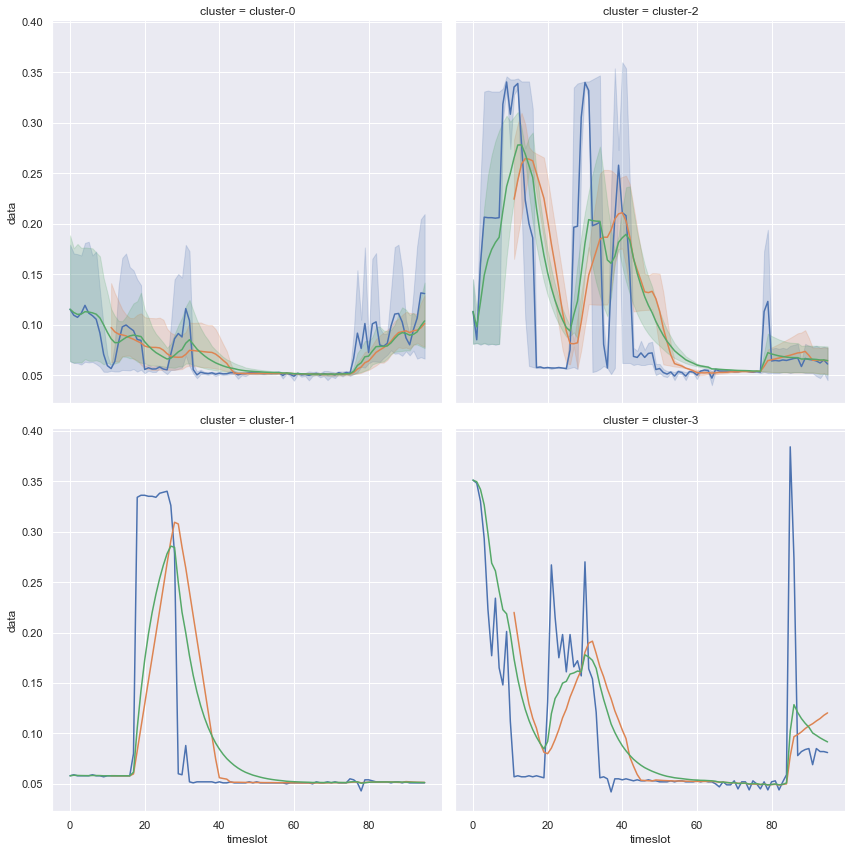

In [304]:
clusterMap = sns.FacetGrid(pdma[(pdma['type'] == 'exponential moving average') 
                               | (pdma['type'] == 'processingData')
                               | (pdma['type'] == 'movingaverage') 
                               ], col = 'cluster', col_wrap=2, height=6)
clusterMap.map(sns.lineplot, "timeslot", "data", "type")